# EXPLAINABILITY PLOTS 

## Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier
import matplotlib.pyplot as plt
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show
import geopandas as gpd
import pickle

## Upload data and sorting

In [2]:
file_model = 'Outputs/modelSU.pkl'
ebm= pickle.load(open(file_model, 'rb'))

In [14]:
data=gpd.read_file('Data/SUs.shp')

In [3]:
file_cov = 'Variable_Selection/variable_selection.pkl'
results_auc= pickle.load(open(file_cov, 'rb'))

In [4]:
subs=results_auc[5]
sel_var=subs['Selected Features']

In [5]:
from interpret import show
show(ebm.explain_global())

## GLOBAL EXPLAINATION

### Overall Importances

In [ ]:
names=['Rainfall anomaly','Catchment ID','SU Area','Slope st.dev.','Soil','Land cover', 'Lithology','Catchment slope angle', 
'Contributing area','Rainfall anomaly & Preparatory rainfall']
importances=ebm.term_importances()
df=pd.DataFrame({'names':names,'importances':importances})
df.sort_values('importances',inplace=True, ascending=False)
plt.bar(df.names, df.importances, width=0.5,facecolor='grey', edgecolor='black', align='center', 
               linewidth=1.0,alpha=0.7)
plt.xticks(rotation=90,family='calibri',fontsize=10)
plt.ylabel('Mean absolute score',fontweight='bold')
plt.savefig('Outputs/plots/overall_importances.png',dpi=300,bbox_inches='tight')
plt.show()

### Feature effects on prediction

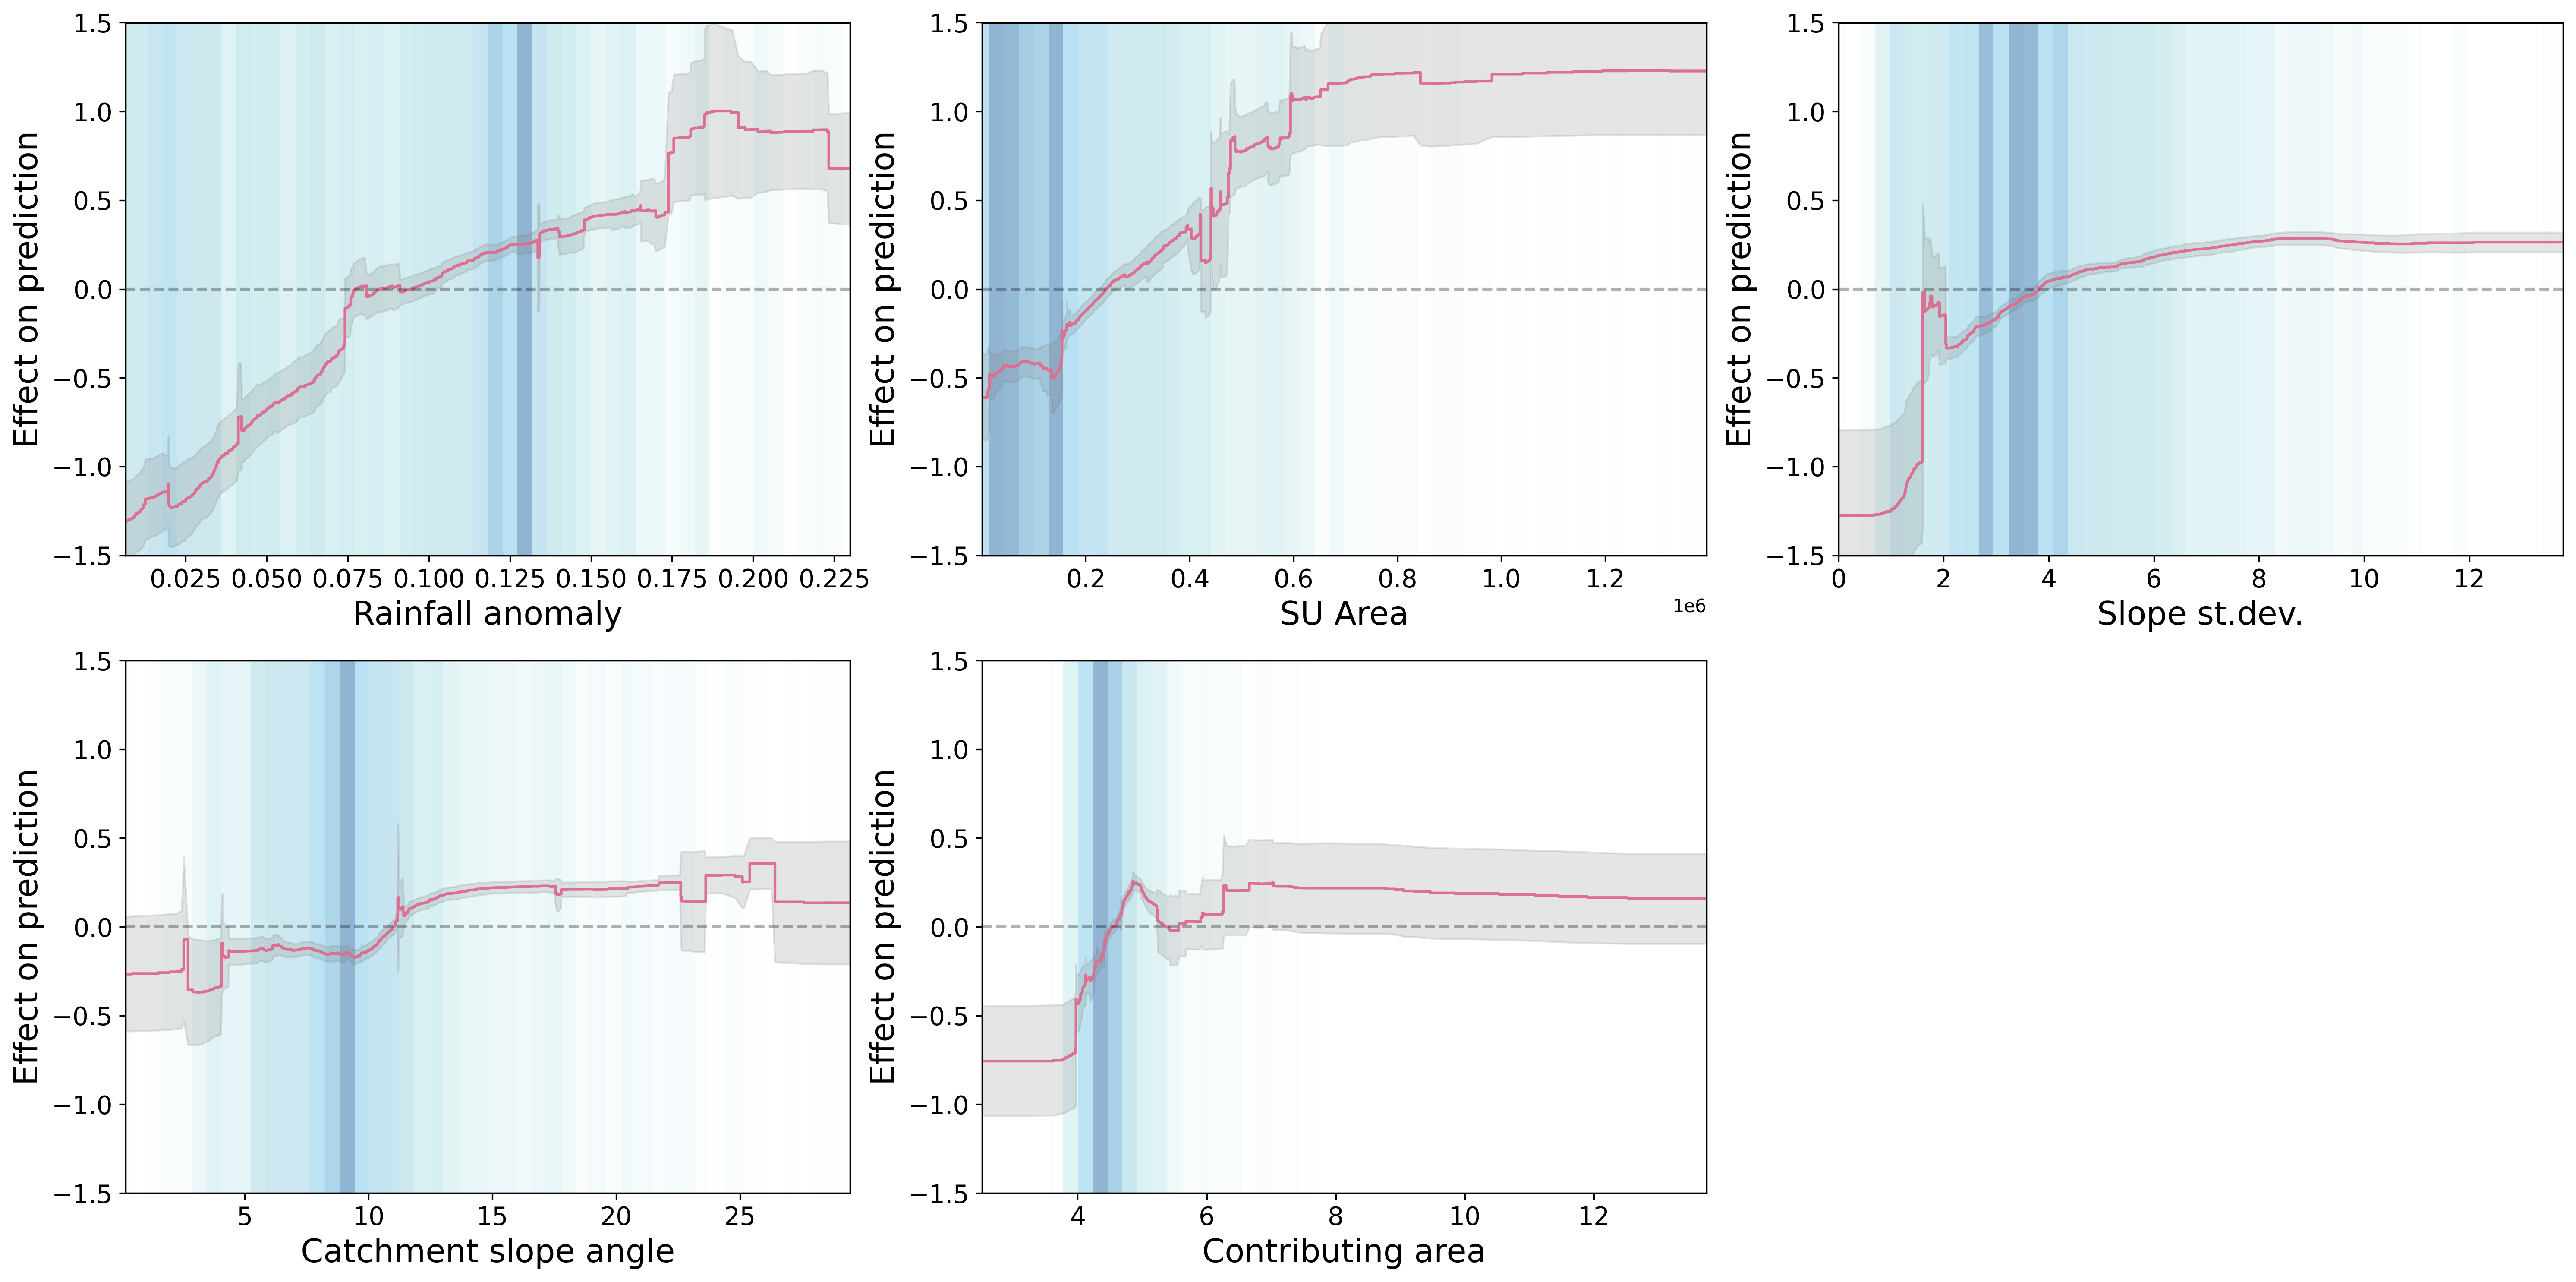

In [11]:
import plots_EBM
names=['Rainfall anomaly','SU Area','Slope st.dev.','Catchment slope angle', 'Contributing area']
indx=[0,2,3,7,8]
cont_effects=plots_EBM.plot_continuos_effects(ebm,indx,names)
cont_effects.savefig('Outputs/plots/continuos_effects.png', dpi=300)
plt.show()  

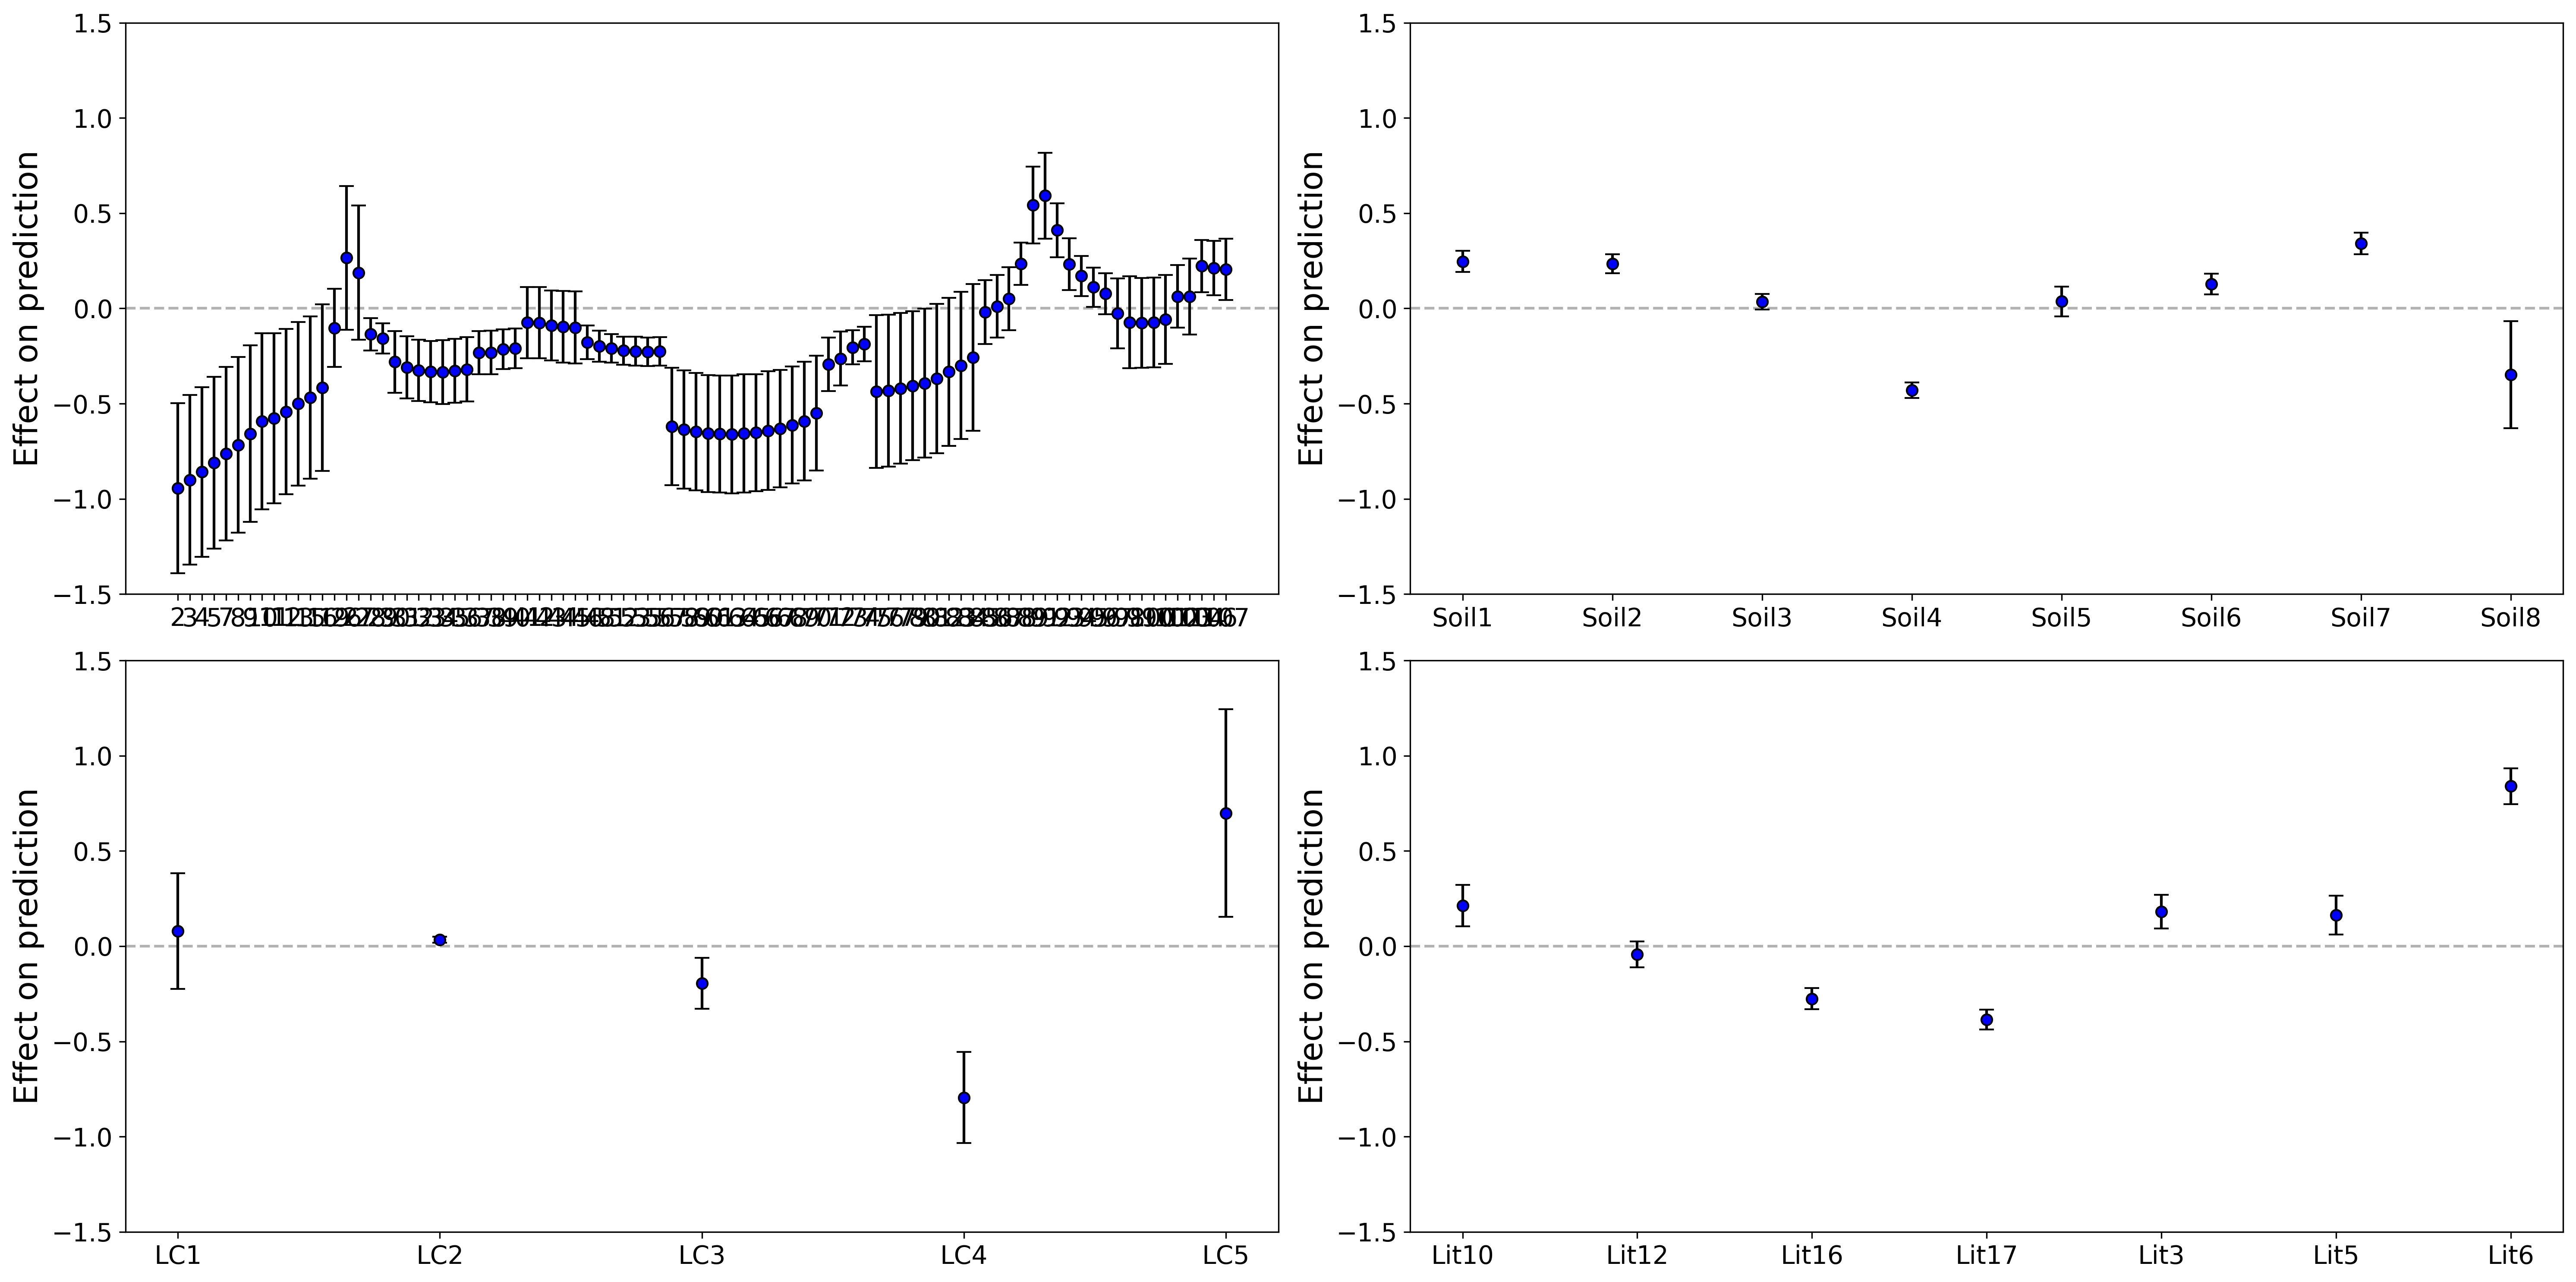

In [12]:
names=['Catchment','soil','lcover','litho']
indx=[1,4,5,6]
cat_effects=plots_EBM.plot_categorical_effects(ebm,indx,names)
cat_effects.savefig('Outputs/plots/categorical_effects.png', dpi=300)
plt.show()

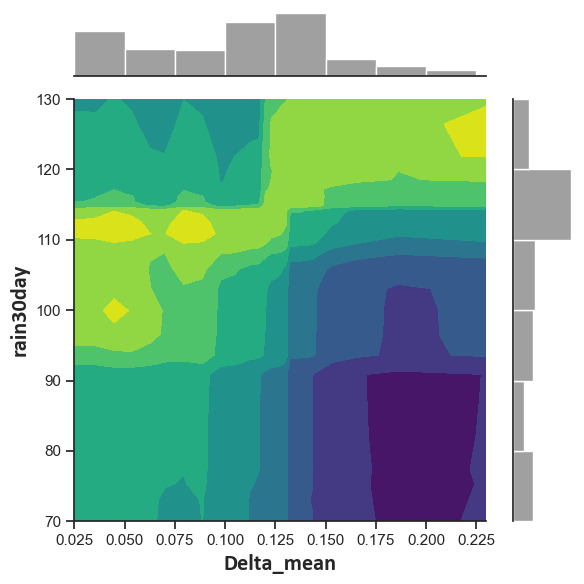

In [15]:
feature_index = 9
interaction=plots_EBM.plot_interaction(data, 'Delta_mean', 'rain30day', feature_index, ebm)
interaction.savefig('Outputs/plots/interaction.png', dpi=300)
plt.show()


### Local plots

In [16]:
litho = ['Lit3', 'Lit5', 'Lit6', 'Lit10', 'Lit12', 'Lit16', 'Lit17']
data['litho'] = data[litho].idxmax(axis=1)
data['litho']=data.litho.astype('category')
lcover=['LC1','LC2', 'LC3', 'LC4', 'LC5', 'LC7']
data['lcover']=data[lcover].idxmax(axis=1)
data['lcover']=data.lcover.astype('category')
data['Catchment']=data.Catchment.astype('category')
soil=['Soil1', 'Soil2','Soil3', 'Soil4', 'Soil5', 'Soil6', 'Soil7', 'Soil8']
data['soil'] = data[soil].idxmax(axis=1)
data['soil']=data.soil.astype('category')
X=data[sel_var]
data['Landslide'] = data['Landslide'].replace(np.nan, 0)
y=data.Landslide

In [17]:
ebm.term_scores_[1] = np.zeros_like(ebm.term_scores_[1])
ebm.term_scores_[2] = np.zeros_like(ebm.term_scores_[2])
y_pred=ebm.predict_proba(X)[:, 1]

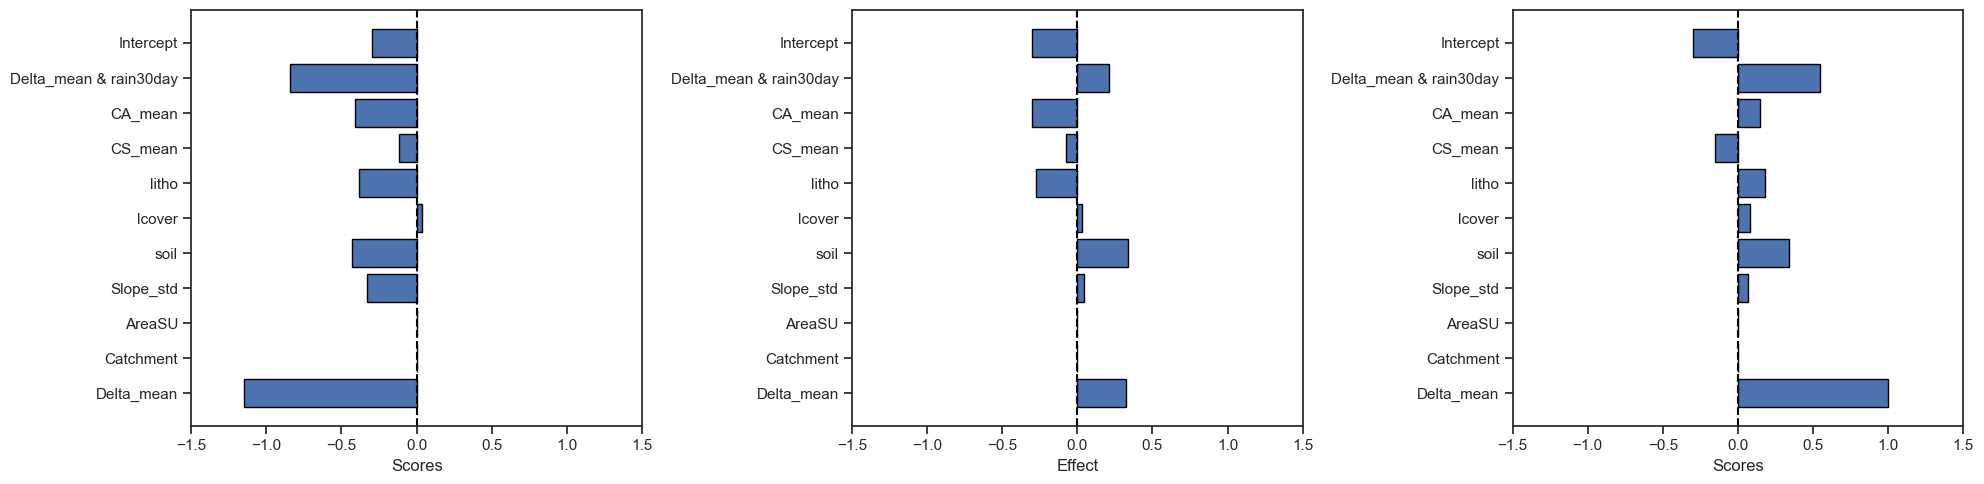

In [21]:
explanations=ebm.explain_local(X[:2050], y[:2050])

names_vl=explanations.data(481)['names']
scores_vl=explanations.data(481)['scores']
intercept=explanations.data(481)['extra']['names']
scor_interc=explanations.data(481)['extra']['scores']
names_vl=names_vl+intercept
scores_vl=scores_vl+scor_interc

names_m=explanations.data(1592)['names']
scores_m=explanations.data(1592)['scores']
names_m=names_m+intercept
scores_m=scores_m+scor_interc

names_vh=explanations.data(1406)['names']
scores_vh=explanations.data(1406)['scores']
names_vh=names_vh+intercept
scores_vh=scores_vh+scor_interc

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].barh(names_vl, scores_vl,edgecolor='black')
axs[0].set_xlim(-1.5,1.5)
axs[0].set_xlabel('Scores')
axs[0].axvline(x=0, color="black", linestyle="--")

axs[1].barh(names_m, scores_m,edgecolor='black')
axs[1].set_xlim(-1.5,1.5)
axs[1].set_xlabel('Effect')
axs[1].axvline(x=0, color="black", linestyle="--")

axs[2].barh(names_vh, scores_vh,edgecolor='black')
axs[2].set_xlim(-1.5,1.5)
axs[2].set_xlabel('Scores')
axs[2].axvline(x=0, color="black", linestyle="--")
plt.tight_layout()
plt.savefig('Outputs/plots/local_example.png',dpi=300)
plt.show()

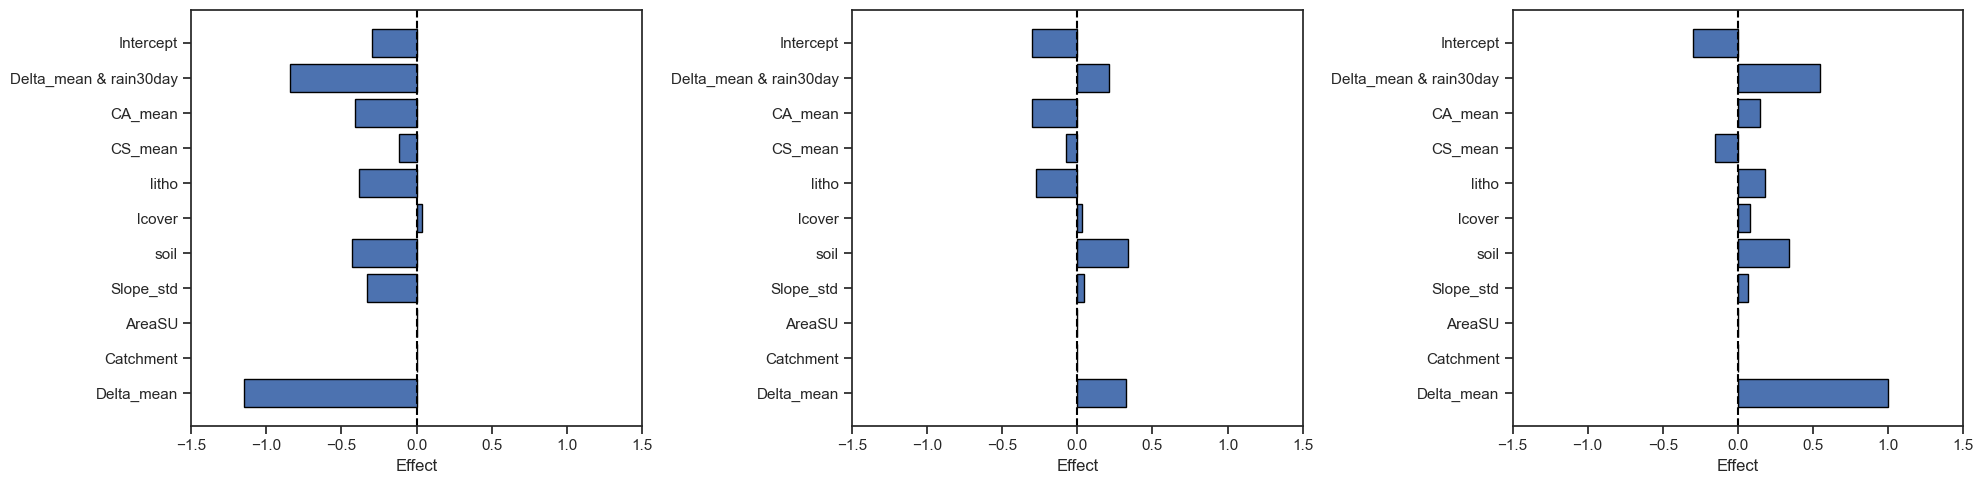

In [25]:
fig=local_effects(ebm,X,481,1592,1406)
plt.show()